# 02807 - COMPUTATIONAL TOOLS FOR DATA SCIENCE

Group 14:
- Marco Malusà s233557
- Adrian Lopez Pirvu s232101
- Qingwen Zeng s232892
- Qiwen Huang s242640
- Matteo Piccagnoni s232713

Course's topics:
- MapReduce
- Frequent Item, A-Priory algorithm
- Graph clustering algorithms, Louvain algorithm
- TF-IDF
- Clustering, k-means

Outside course's topic:
- Linear boundaries for obsolence prediction 

This project wants to analyze a dataset of medicines to extract meaningful insights into their compositions, associated side effects, and usage patterns. The aim is to uncover patterns, relationships, and clusters within the dataset to support pharmacological research, enhance medicine recommendations, and improve understanding of medicine-side effect associations.
The project integrates multiple analytical methods, including sparse matrix analysis, market-basket analysis, community detection, and TF-IDF. Each method plays a crucial role in uncovering patterns and creating interpretable outputs.

## 1. DATA PROCESSING

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import seaborn as sns
import sys

import plotly.express as px # for interactive plots
from wordcloud import WordCloud # for wordclouds
import re  # for regular expressions

import plotly.graph_objects as go

from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from sklearn.utils import murmurhash3_32
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from itertools import combinations
from community import community_louvain  # For Louvain method
import random

from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 

warnings.filterwarnings('ignore') 
random.seed(42)
sns.set_theme()


In [238]:
data = pd.read_csv('medicine_details.csv')
data.head()

Medicine Name  \
0   Avastin 400mg Injection   
1  Augmentin 625 Duo Tablet   
2       Azithral 500 Tablet   
3          Ascoril LS Syrup   
4         Aciloc 150 Tablet   

                                         Composition  \
0                                Bevacizumab (400mg)   
1    Amoxycillin  (500mg) +  Clavulanic Acid (125mg)   
2                               Azithromycin (500mg)   
3  Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...   
4                                 Ranitidine (150mg)   

                                                Uses  \
0  Cancer of colon and rectum Non-small cell lung...   
1                  Treatment of Bacterial infections   
2                  Treatment of Bacterial infections   
3                      Treatment of Cough with mucus   
4  Treatment of Gastroesophageal reflux disease (...   

                                        Side_effects  \
0  Rectal bleeding Taste change Headache Noseblee...   
1  Vomiting Nausea Diarrhea Mucocutaneous candidi...   
2                     Nausea Abdominal pain Diarrhea   
3  Nausea Vomiting Diarrhea Upset stomach Stomach...   
4     Headache Diarrhea Gastrointestinal disturbance   

                           Manufacturer  Excellent Review %  Average Review %  \
0          Roche Products India Pvt Ltd                  22                56   
1  Glaxo SmithKline Pharmaceuticals Ltd                  47                35   
2           Alembic Pharmaceuticals Ltd                  39                40   
3          Glenmark Pharmaceuticals Ltd                  24                41   
4            Cadila Pharmaceuticals Ltd                  34                37   

   Poor Review %  
0             22  
1             18  
2             21  
3             35  
4             29

## 2. MANUFACTURER VS RATING ANALYSIS

### 2.1 FIRST ANALYSIS AND VISUALIZATION

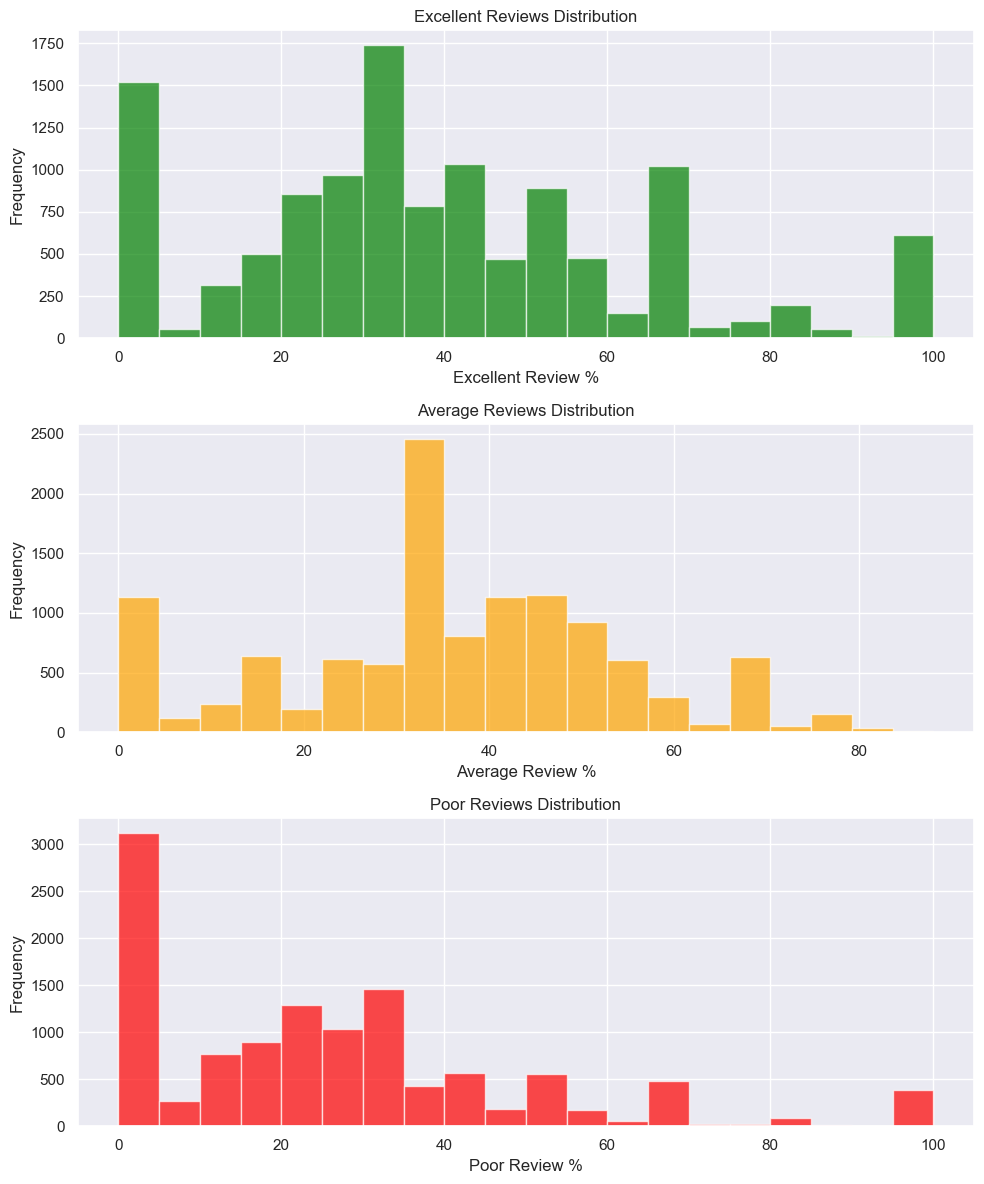

In [239]:
# three plot to see the distribution of the different percentages of reviews
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

axs[0].hist(data['Excellent Review %'], bins=20, color='green', alpha=0.7)
axs[0].set_title('Excellent Reviews Distribution')
axs[0].set_xlabel('Excellent Review %')
axs[0].set_ylabel('Frequency')

axs[1].hist(data['Average Review %'], bins=20, color='orange', alpha=0.7)
axs[1].set_title('Average Reviews Distribution')
axs[1].set_xlabel('Average Review %')
axs[1].set_ylabel('Frequency')

axs[2].hist(data['Poor Review %'], bins=20, color='red', alpha=0.7)
axs[2].set_title('Poor Reviews Distribution')
axs[2].set_xlabel('Poor Review %')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [240]:
# Define weights for each rating category. First element is for Excellent Review %, second for Average Review %, and third for Poor Review % (won't be multiplying since its weight is 0)
WEIGHTS = [10, 5, 0] 
data['Rating Score'] = (data['Excellent Review %'] * WEIGHTS[0] + data['Average Review %'] * WEIGHTS[1]) / 100 # Divide by 100 to get the average percentage
data[['Medicine Name','Excellent Review %', 'Average Review %', 'Poor Review %','Rating Score']].head()


Medicine Name  Excellent Review %  Average Review %  \
0   Avastin 400mg Injection                  22                56   
1  Augmentin 625 Duo Tablet                  47                35   
2       Azithral 500 Tablet                  39                40   
3          Ascoril LS Syrup                  24                41   
4         Aciloc 150 Tablet                  34                37   

   Poor Review %  Rating Score  
0             22          5.00  
1             18          6.45  
2             21          5.90  
3             35          4.45  
4             29          5.25

In [241]:
# counting the number of manufacturers
manufacturer_counts = data['Manufacturer'].value_counts()

# manufacturers with more than 10 products
top_manufacturers = manufacturer_counts[manufacturer_counts > 10]

# Statistics
manufacturer_summary = manufacturer_counts.describe().to_frame().T
top_manufacturers_summary = top_manufacturers.describe().to_frame().T

# Concatenate both tables
summary = pd.concat([manufacturer_summary, top_manufacturers_summary], axis=0)
summary.index = ['All Manufacturers', 'Top Manufacturers']
summary

count       mean         std   min   25%   50%   75%    max
All Manufacturers  759.0  15.579710   60.143725   1.0   1.0   2.0   7.0  820.0
Top Manufacturers  141.0  72.992908  124.439974  11.0  15.0  29.0  57.0  820.0

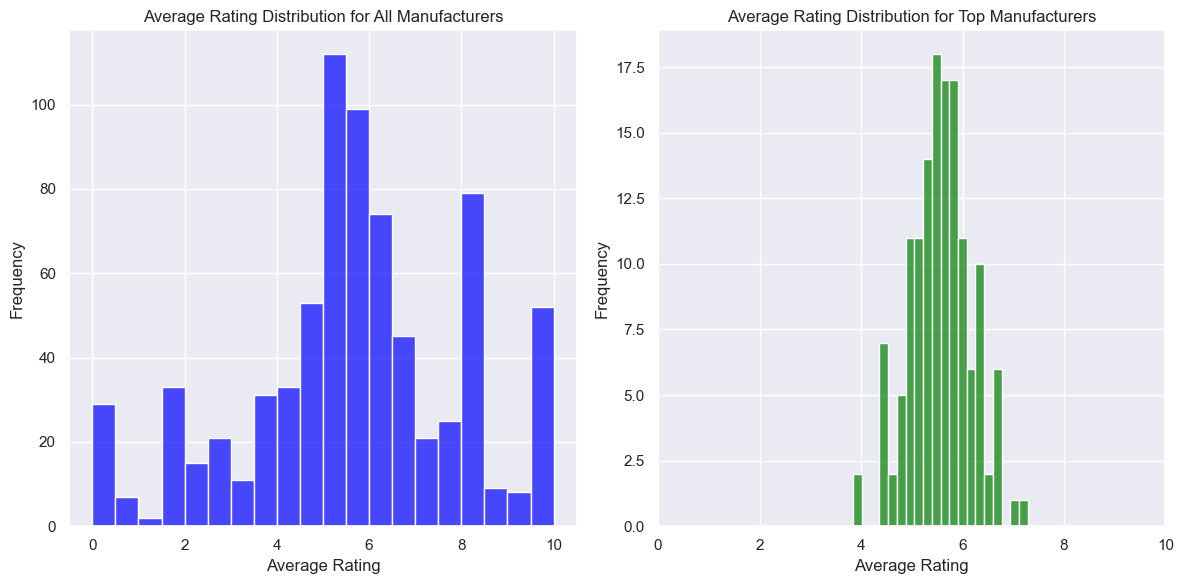

In [242]:
# calculating the average rating for each manufacturer (maybe add filter of more than n medicines)
manufacturer_ratings = data.groupby('Manufacturer')['Rating Score'].mean().sort_values(ascending=False)

# Analysis for the manufacturers with more than 10 products
top_manufacturer_ratings = data[data['Manufacturer'].isin(top_manufacturers.index)].groupby('Manufacturer')['Rating Score'].mean().sort_values(ascending=False)

# Distribution of the average rating for all manufacturers
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(manufacturer_ratings, bins=20, color='blue', alpha=0.7, ax=axs[0])
axs[0].set_title('Average Rating Distribution for All Manufacturers')
axs[0].set_xlabel('Average Rating')
axs[0].set_ylabel('Frequency')

# Distribution of the average rating for the top manufacturers
sns.histplot(top_manufacturer_ratings, bins=20, color='green', alpha=0.7, ax=axs[1])
axs[1].set_title('Average Rating Distribution for Top Manufacturers')
axs[1].set_xlabel('Average Rating')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 10)

plt.tight_layout()
plt.show()

### 2.1 CLUSTERING

Using the following code, we perform manufacturer clustering based on their ratings and their contribution to overall medicine production. This analysis helps identify which manufacturers are most prominent within each rating cluster. To prevent the most prolific manufacturers from dominating every cluster, we weighted their presence in each cluster by the total number of medicines they produce.

In [243]:
grouping_df = data.loc[:, ['Rating Score', 'Manufacturer']]

# linear boundaries
bins = [0, 2.5, 5, 7.5, 10]
labels = [0, 1, 2, 3]
grouping_df['group'] = pd.cut(grouping_df['Rating Score'], bins=bins, labels=labels, right=False)

# calculate the mean 
group_means = grouping_df.groupby('group')['Rating Score'].mean()

# Sort groups by mean rating in descending order
sorted_groups = group_means.sort_values(ascending=False).index

# Map the original groups to the sorted groups
group_mapping = {old: new for new, old in enumerate(sorted_groups)}
grouping_df['group'] = grouping_df['group'].map(group_mapping)

# Sort by group index 
group_counts = grouping_df['group'].value_counts().sort_index()

# color map for groups (better understanding)
group_color_map = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

C:\Users\AdrianLopez\AppData\Local\Temp\ipykernel_17960\2754243446.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



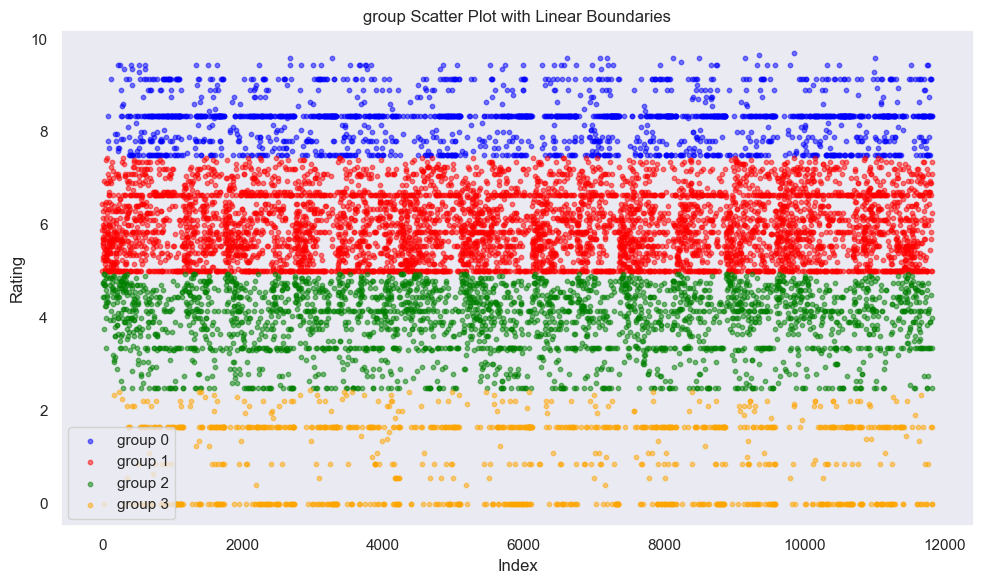

In [244]:
# Scatter plot 
plt.figure(figsize=(10, 6))

for group in range(4):
    group_data = grouping_df[grouping_df['group'] == group]
    plt.scatter(
        group_data.index,
        group_data['Rating Score'],
        label=f'group {group}',
        color=group_color_map[group],  # Use fixed color
        s=10,
        alpha=0.5 
    )

plt.title("group Scatter Plot with Linear Boundaries")
plt.xlabel("Index")
plt.ylabel("Rating")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

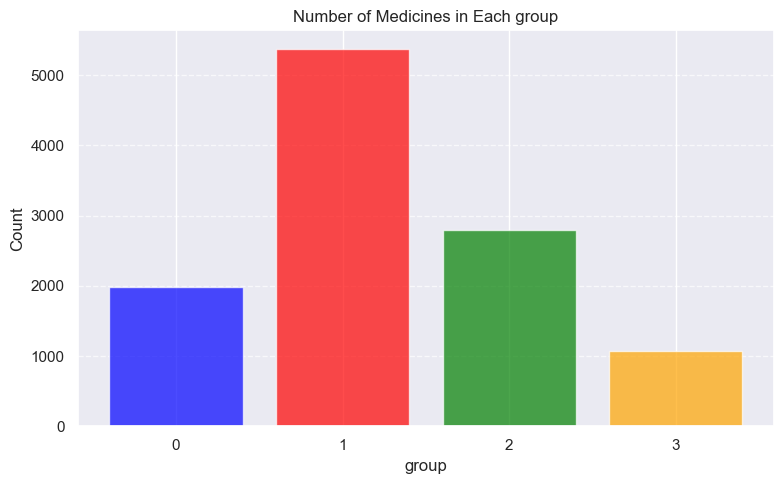

In [245]:
# Bar plot 
plt.figure(figsize=(8, 5))

plt.bar(
    group_counts.index,  # Keep the original group order from the grouping
    group_counts.values, 
    color=[group_color_map[group] for group in group_counts.index],  # Keep color consistent
    alpha=0.7
)

plt.title("Number of Medicines in Each group")
plt.xlabel("group")
plt.ylabel("Count")
plt.xticks(range(4)) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As shown in the plot, Cluster 1, which contains medicines with ratings between 5 and 7, is the most populous cluster. In contrast, Cluster 3, which includes medicines with ratings between 0 and 2, is the least populated. This observation is also supported by the scatter plot. 

In [246]:

# Count the number of medicines per manufacturer in each group
manufacturer_group_matrix = pd.crosstab(grouping_df['group'], grouping_df['Manufacturer'])

# Find the top 2 manufacturers
top_manufacturers_per_group = {}

for group, manufacturers in manufacturer_group_matrix.iterrows():
    manufacturer_weights = {}

    # For each manufacturer in the group, calculate the weighted presence
    for manufacturer, count in manufacturers.items():
        if count > 0:  # Only consider manufacturers that appear in the group
            # Weighting the appearance by the proportion of the manufacturer's total medicines that appear in this group
            total_count = grouping_df['Manufacturer'].value_counts().get(manufacturer, 1) 
            weighted_count = count / total_count
            manufacturer_weights[manufacturer] = weighted_count

    # Sort the manufacturers by the weighted presence 
    sorted_manufacturers = sorted(manufacturer_weights.items(), key=lambda x: x[1], reverse=True)

    # Get the top 2 manufacturers
    top_manufacturers_per_group[group] = [sm[0] for sm in sorted_manufacturers[:2]]

print("\nTop 2 Manufacturers per group (Proportioned by Medicine Production):")
for group, manufacturers in top_manufacturers_per_group.items():
    if len(manufacturers) == 2:
        print(f"group {group}: {manufacturers[0]} and {manufacturers[1]}")
    else:
        print(f"group {group}: {manufacturers[0]}")


Top 2 Manufacturers per group (Proportioned by Medicine Production):
group 3: Aarti Life Science and Adonis Phytoceuticals Pvt Ltd
group 2: Aprazer Healthcare Pvt Ltd and Arjan Biotech
group 1: AAA Pharma Trade Pvt Ltd and AS Lifesciences
group 0: AGIO Pharmaceuticals Ltd and Aceon Pharma


The manufacturers listed above are the most prominent in each cluster, weighted by the number of medicines they produce. This helps identify which manufacturers dominate each cluster, providing insight into their overall performance and quality.

## 3. SIDE EFFECT APPEREANCES 

Using a word cloud plot we want to see and visualize which are the most common side effects in our dataset

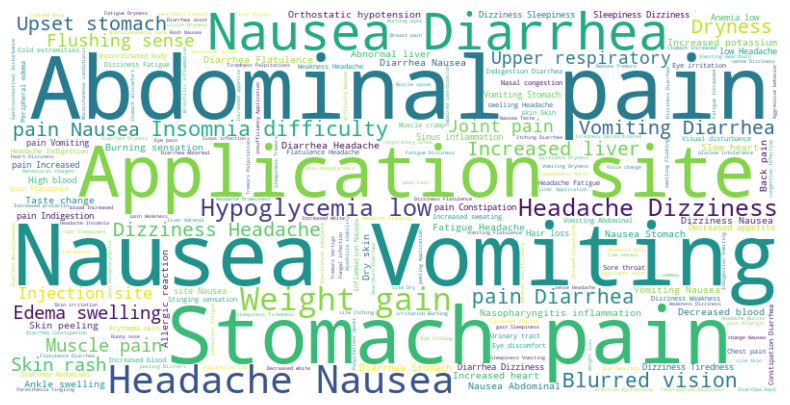

In [247]:
# Step 1: Split side effects based on capital letters and clean up the list
data['Side_effects'] = data['Side_effects'].apply(lambda x: re.findall(r'[A-Z][a-z]*\s?[a-z]*', x))

# Step 2: Combine all side effects into a single string for word cloud
all_side_effects = ' '.join([' '.join(effect) for effect in data['Side_effects']])

# Step 3: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_side_effects)

# Step 4: Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Visualizing the occurrence of side effects using a word cloud is an engaging way to explore the relationship between drug components and their associated side effects, as we will demonstrate in the following section of the notebook.

## 4. SPARSE MATRIX and BASKET ANALYSIS

### 4.1 Sparse Matrix Representation and Analysis

This section focuses on converting the medicine composition data into a sparse matrix format for efficient storage and processing. 
The steps include:
- Mapping Components: Assigning unique indices to components for a more compact representation.
- Sparse Matrix Conversion: Replacing component names with indices in the DataFrame.
- Sparsity Analysis: Calculating the percentage of zero and non-zero elements to understand the data distribution.
- Tuple-Based Representation: Extracting non-zero elements into tuples for efficient storage and further processing.
- Reverse Mapping: Mapping indices back to original component names for interpretation.


This code defines two functions to process and organize data about medicine compositions. The **map_composition** function extracts detailed information about each medicine's components, including their names and quantities, while the **reduce_components** function aggregates this information into a structured format, showing the quantities of each unique component for all medicines.

In [248]:
# Map function to parse compositions and emit intermediate results
def map_composition(row):
    medicine_name = row["Medicine Name"]
    composition = row["Composition"]
    
    components = []
    for component in composition.split("+"):
        component = component.strip()
        name, quantity = component.rsplit("(", 1)
        name = name.strip()
        quantity = quantity.strip(")")
        components.append((medicine_name, name, quantity))
    return components

# Reduce function to aggregate results into a final structure
def reduce_components(mapped_data):
    # Collect all unique components
    unique_components = set()
    for entry in mapped_data:
        _, component_name, _ = entry
        unique_components.add(component_name)
    
    # Initialize the result structure
    result = defaultdict(lambda: {component: "" for component in unique_components})
    
    # Populate the structure with quantities
    for medicine_name, component_name, quantity in mapped_data:
        result[medicine_name][component_name] = quantity
    
    return result

In [249]:
# Read the first two columns of the data corresponding to Medicine Name and Composition
df = pd.read_csv('medicine_details.csv', usecols=['Medicine Name','Composition'])

# Apply the map function to all rows
mapped_data = []
for _, row in df.iterrows():
    mapped_data.extend(map_composition(row))

# Apply the reduce function
reduced_data = reduce_components(mapped_data)

# Convert the reduced data to a DataFrame
map_reduce_df = pd.DataFrame.from_dict(reduced_data, orient="index").reset_index()
map_reduce_df.rename(columns={"index": "Medicine Name"}, inplace=True)

# Display the final DataFrame (It is okay that most of values are empty)
map_reduce_df.iloc[:5, :10]

Medicine Name Rutoside Betahistine Fusidic Acid Bromhexine  \
0   Avastin 400mg Injection                                                
1  Augmentin 625 Duo Tablet                                                
2       Azithral 500 Tablet                                                
3          Ascoril LS Syrup                                                
4         Aciloc 150 Tablet                                                

  Zinc pyrithione Ibandronic Acid Sodium Fluoride Verapamil Sodium Citrate  
0                                                                           
1                                                                           
2                                                                           
3                                                                           
4

### 4.2 Further storaging saving

**Replacement of values by indexes**

This part of the code assigns a unique index to each distinct value in the DataFrame (excluding empty strings) and replaces the original values with their corresponding indices. This transformation is likely preparing the data for further processing, such as creating a sparse matrix.

In [250]:
# Get unique values from the DataFrame (excluding "")
unique_values = sorted(set(map_reduce_df.values.flatten()) - {""})
value_mapping = {v: i for i, v in enumerate(unique_values)}  # Map each unique value to an index

# Replace DataFrame values with indices
values_as_index_df = map_reduce_df.set_index("Medicine Name").map(lambda x: value_mapping.get(x, -1)) 
display(values_as_index_df.iloc[:5, :10])

# Display first 5 unique values and their corresponding indices
print("\nValue Mapping Example:")
for value, index in list(value_mapping.items())[:5]:
    print(f"{value} -> {index}")

Rutoside  Betahistine  Fusidic Acid  Bromhexine  \
Medicine Name                                                               
Avastin 400mg Injection         -1           -1            -1          -1   
Augmentin 625 Duo Tablet        -1           -1            -1          -1   
Azithral 500 Tablet             -1           -1            -1          -1   
Ascoril LS Syrup                -1           -1            -1          -1   
Aciloc 150 Tablet               -1           -1            -1          -1   

                          Zinc pyrithione  Ibandronic Acid  Sodium Fluoride  \
Medicine Name                                                                 
Avastin 400mg Injection                -1               -1               -1   
Augmentin 625 Duo Tablet               -1               -1               -1   
Azithral 500 Tablet                    -1               -1               -1   
Ascoril LS Syrup                       -1               -1               -1   
Aciloc 150 Tablet                      -1               -1               -1   

                          Verapamil  Sodium Citrate  Isoxsuprine  
Medicine Name                                                     
Avastin 400mg Injection          -1              -1           -1  
Augmentin 625 Duo Tablet         -1              -1           -1  
Azithral 500 Tablet              -1              -1           -1  
Ascoril LS Syrup                 -1              -1           -1  
Aciloc 150 Tablet                -1              -1           -1


Value Mapping Example:
0.0003% w/w -> 0
0.0007ml -> 1
0.001% w/v -> 2
0.0015% w/v -> 3
0.002% w/w -> 4


In [251]:
# Original DataFrame size bytes
map_reduce_df_size = sys.getsizeof(map_reduce_df)

# Sparse matrix + value mapping bytes
value_as_index_df_size = sys.getsizeof(values_as_index_df)
value_mapping_size = sys.getsizeof(value_mapping)

# Sum of sizes of elements required for the new representation
resulting_size = value_as_index_df_size + value_mapping_size

# Display differences in sizes
print(f"map_reduce DataFrame Size: {map_reduce_df_size} bytes")
print(f"value_as_index DataFrame Size: {value_as_index_df_size} bytes")
print(f"value_mapping Size: {value_mapping_size} bytes")
print(f"Total Size: {resulting_size} bytes")

# Percentage reduction in size
reduction_percentage = ((map_reduce_df_size - resulting_size) / map_reduce_df_size) * 100
print(f"Reduction: {reduction_percentage:.2f}%")

map_reduce DataFrame Size: 598644939 bytes
value_as_index DataFrame Size: 98380246 bytes
value_mapping Size: 415152 bytes
Total Size: 98795398 bytes
Reduction: 83.50%


This code analyzes sparsity and non-zero elements in the sparse matrix.

In [252]:
# Calculate statistics
total_elements = values_as_index_df.size
total_zeros = (values_as_index_df == -1).sum().sum()
total_non_zeros = total_elements - total_zeros
percentage_zeros = (total_zeros / total_elements) * 100

print(f"Total elements: {total_elements}")
print(f"Percentage of zeros: {percentage_zeros:.2f}%")

Total elements: 12199378
Percentage of zeros: 99.86%


**Triple method**

This code extracts non-zero elements as tuples for efficient storage and processing.

In [253]:
row_array = values_as_index_df.index.tolist()
column_array = values_as_index_df.columns.tolist()

# Create a list of tuples (row_index, column_index, value) for non-zero values
non_zero_tuples = [
    (row_idx, col_idx, values_as_index_df.iloc[row_idx, col_idx])
    for row_idx in range(values_as_index_df.shape[0])
    for col_idx in range(values_as_index_df.shape[1])
    if values_as_index_df.iloc[row_idx, col_idx] != -1
]

In [254]:
# Print the size of the data structures
row_array_size = sys.getsizeof(row_array)
column_array_size = sys.getsizeof(column_array)
non_zero_tuples_size = sys.getsizeof(non_zero_tuples)

# Calculate the total size of the data structures required for triple representation
total_size = value_mapping_size + row_array_size + column_array_size + non_zero_tuples_size

# Display the sizes
print(f"Total Triple Size: {total_size} bytes")

# Percentage reduction in size
reduction_percentage = ((map_reduce_df_size - total_size) / map_reduce_df_size) * 100
print(f"Reduction: {reduction_percentage:.2f}%")

Total Triple Size: 669488 bytes
Reduction: 99.89%


This code create a reverse map indices to their original component names for readability.

In [255]:
# This dictionary maps each unique value to its index
reverse_mapping = {i: v for v, i in value_mapping.items()}  # Reverse the dictionary to get values from indices

# Print some tuples along with their components
print("Sample tuples with indexed values and their components:")
for i, (row_idx, col_idx, value_index) in enumerate(non_zero_tuples[:5]):  # Limit to first 5 tuples
    original_value = reverse_mapping.get(value_index, "Unknown")  # Get the original value using the reverse mapping
    print(f"Tuple {i+1}: (Row: {row_idx}, Column: {col_idx}, Indexed Value: {value_index}, Original Component: {original_value})")

Sample tuples with indexed values and their components:
Tuple 1: (Row: 0, Column: 42, Indexed Value: 472, Original Component: 400mg)
Tuple 2: (Row: 1, Column: 244, Indexed Value: 521, Original Component: 500mg)
Tuple 3: (Row: 1, Column: 962, Indexed Value: 220, Original Component: 125mg)
Tuple 4: (Row: 2, Column: 206, Indexed Value: 521, Original Component: 500mg)
Tuple 5: (Row: 3, Column: 198, Indexed Value: 529, Original Component: 50mg/5ml)


These transformations allow for scalable processing of large datasets and facilitate operations such as similarity computation or recommendation systems based on medicine composition.

### 4.3 Market-Basket Analysis


In this part, the aim is to uncover relationships between medicine components and their associated side effects using a market basket analysis approach. Here, this methodology was adapted to explore frequent combinations of components in medicines and associate them with potential side effects.
Understanding these associations can help to identify common side effects caused by frequently occurring combinations of components, support pharmacological research and improve medical recommendations.
The steps are:
- Data Preparation: Extract and clean the dataset, organizing medicine compositions and their associated side effects into transactions.
- Frequent Itemset Mining: Apply the A-Priori algorithm to identify common combinations of medicine components based on a minimum support threshold.
- Association Mapping: Link frequent itemsets with their reported side effects, creating a mapping of component combinations to potential effects.
- Insight Extraction: Display and interpret the associations between medicine compositions and side effects to uncover actionable patterns.

These following functions are: **split_side_effects**, extracts individual side effects from a text string using a pattern for words starting with uppercase letters; **count_compositions**, determines the number of components in a chemical composition by splitting the string on '+' symbols; **a_priori**, implements the A-Priori algorithm to find frequent itemsets in transaction data, filtering them based on a minimum support threshold.

In [256]:
def split_side_effects(side_effects):
    # Regular expression to match words starting with uppercase letters (and followed by lowercase letters)
    return re.findall(r'[A-Z][a-z]*\s?[a-z]*', side_effects)

# Function to count the number of components in a chemical composition
def count_compositions(composition):
    # Split the composition string by '+' to identify individual components
    components = composition.split('+')
    return len(components)

# Convert sparse matrix tuples to transactions
def convert_sparse_to_transactions(non_zero_tuples, row_array, column_array):
    transactions = defaultdict(set)
    for row_idx, col_idx, _ in non_zero_tuples:
        medicine_name = row_array[row_idx]
        component = column_array[col_idx]
        transactions[medicine_name].add(component)
    return transactions

# Function to apply the A-Priori algorithm
def a_priori(transactions, min_support):
    
    # Count occurrences of individual items
    item_counts = defaultdict(int)
    for transaction in transactions.values():
        for item in transaction:
            item_counts[item] += 1

    # Calculate the number of transactions
    num_transactions = len(transactions)

    # Identify frequent 1-itemsets
    frequent_itemsets = {item: count / num_transactions for item, count in item_counts.items() if count / num_transactions >= min_support}

    # Initialize variables to find larger itemsets
    current_itemsets = list(frequent_itemsets.keys())  # Start with frequent 1-itemsets
    all_frequent_itemsets = dict(frequent_itemsets)  # Store all discovered frequent itemsets
    k = 2  # Length of itemsets to generate

    # Iteratively find larger itemsets
    while current_itemsets:
        next_itemsets = defaultdict(int)

        # Generate candidate k-itemsets and count their occurrences
        for transaction in transactions.values():
            for itemset in combinations(transaction, k):
                if all(item in transaction for item in itemset):
                    next_itemsets[itemset] += 1
        
        # Filter k-itemsets based on the minimum support threshold
        frequent_itemsets_k = {itemset: count / num_transactions for itemset, count in next_itemsets.items() if count / num_transactions >= min_support}

        # Stop if no new frequent itemsets are found
        if not frequent_itemsets_k:
            break
        
        # Update the overall list of frequent itemsets
        all_frequent_itemsets.update(frequent_itemsets_k)
        current_itemsets = list(frequent_itemsets_k.keys())
        k += 1  # Increase itemset size for the next iteration

    return all_frequent_itemsets

This code creates two dictionaries, **transactions** and **side_effects_dict**, which are essential for the analysis of compositions and side effects.

In [257]:
df = pd.read_csv('medicine_details.csv', usecols=['Composition', 'Side_effects', 'Medicine Name'])

#Map sparse matrix tuples and side effects
row_array = df['Medicine Name'].tolist()
column_array = df['Composition'].apply(lambda x: x.split(' + ')).explode().unique().tolist()


# Convert sparse matrix tuples to transactions
transactions = convert_sparse_to_transactions(non_zero_tuples, row_array, column_array)

# Create side_effects_dict
side_effects_dict = defaultdict(list)
for _, row in df.iterrows():
    side_effects_dict[row["Medicine Name"]] = split_side_effects(row["Side_effects"])

The following code counts the number of components in each medicine's composition and then calculates statistics about the frequency of these counts.

In [258]:
# Add a new column to the DataFrame to store the composition counts
df['Composition Count'] = df['Composition'].apply(count_compositions)

# Calculate statistics for the number of components (composition counts)
composition_count_stats = df['Composition Count'].value_counts().sort_index()

# Convert the composition count statistics to a DataFrame for table output
composition_count_stats_df = composition_count_stats.reset_index()
composition_count_stats_df.columns = ['Number of Components', 'Frequency']

# Display the statistics as a table
composition_count_stats_df.sort_values(by='Number of Components', ascending=True)

Number of Components  Frequency
0                     1       7069
1                     2       3596
2                     3        933
3                     4        150
4                     5         51
5                     6         16
6                     7          7
7                     8          2
8                     9          1

Implementation of an A-priori algorithm for finding frequent itemsets in transactional data. It is used to dentify which components (or combinations of components) are commonly used in medicines.

In [259]:
# Apply A-Priori algorithm
min_support = 0.003
frequent_itemsets = a_priori(transactions, min_support)

df_results = pd.DataFrame(
    [(itemset, support) for itemset, support in frequent_itemsets.items()],
    columns=["Itemset", "Support"]
).sort_values(by="Support", ascending=False)

# top 5 frequent itemsets in a table format
df_results.head()

Itemset   Support
50                        Univestin (250mg)  0.059318
33                        Menthol (1mg/5ml)  0.033819
42                      Albendazole (400mg)  0.033283
7               Aluminium Hydroxide (0.5mg)  0.031404
137  (Menthol (1mg/5ml), Univestin (250mg))  0.028809

The following code identifies the side effects associated with each frequent itemset found using the A-Priori algorithm, enabling the analysis of relationships between groups of medicine components and their potential side effects. It then visualizes these associations with a Sankey diagram, illustrating the flow from medicine combinations (source nodes) to their related side effects (target nodes) in an interactive format.

In [260]:
# Create a dictionary to map medicine combinations (itemsets) to their associated side effects
itemset_side_effects = defaultdict(set)

# Loop through transactions to associate itemsets with side effects
for medicine_name, components in transactions.items():
    # Retrieve the side effects associated with the current medicine
    side_effects = side_effects_dict[medicine_name]
    
    # Iterate through all frequent itemsets
    for itemset in frequent_itemsets:
        # Sort the itemset to ensure consistent ordering
        sorted_itemset = tuple(sorted(itemset))
        
        # Check if all items in the itemset are present in the medicine components
        if all(item in components for item in itemset):
            # Add the side effects of the medicine to the current itemset
            itemset_side_effects[sorted_itemset].update(side_effects)

# Prepare data for the Sankey diagram
node_labels = []       # Labels for all nodes (medicine combinations + side effects)
links_source = []      # Source node indices
links_target = []      # Target node indices
links_value = []       # Flow values (e.g., set to 1 or a measure of strength)

# Construct nodes and links
node_set = set()        # Set to store unique nodes
for itemset, side_effects in itemset_side_effects.items():
    # Convert the medicine combination (itemset) to a string label
    itemset_label = ", ".join(itemset)
    if itemset_label not in node_set:
        # Add unique medicine combination node
        node_set.add(itemset_label)
        node_labels.append(itemset_label)
    
    # Add side effect nodes and create links
    for effect in side_effects:
        if effect not in node_set:
            # Add unique side effect node
            node_set.add(effect)
            node_labels.append(effect)
        
        # Create links between the medicine combination and side effect
        links_source.append(node_labels.index(itemset_label))
        links_target.append(node_labels.index(effect))
        links_value.append(1)  # Set link weight to 1 (can be adjusted if needed)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=180,          # Padding between nodes
        thickness=75,     # Thickness of the nodes
        line=dict(color="black", width=0.1),  # Node borders
        label=node_labels  # Node labels
    ),
    link=dict(
        source=links_source,  # Source node indices
        target=links_target,  # Target node indices
        value=links_value     # Flow values
    )
))

# Customize layout and display the figure
fig.update_layout(
    title_text="Medicine Combinations and Associated Side Effects",  # Title of the diagram
    font=dict(size=8, color="black"),    # Font settings for labels
    plot_bgcolor="white",                # Background color of the plot
    width=800,                           # Diagram width
    height=1000                          # Diagram height
)
fig.show()


## 5. Community Detection
Identify and group similar documents into communities based on their content using Minhashing and Locality Sensitive Hashing (LSH). The steps are: 
- Data Preprocessing: The dataset is cleaned by removing stopwords and unnecessary terms from the Uses column to ensure meaningful comparisons.
- Shingle Generation: Documents are split into overlapping sequences of words (k-shingles) to represent their content.
- Minhashing: A signature matrix is created for each document to approximate the Jaccard similarity between documents efficiently.
- Locality Sensitive Hashing (LSH): Documents are grouped into buckets based on their Minhash signatures to find potential candidate pairs for similarity analysis.
- Graph Construction: A graph is built with documents as nodes and edges representing potential similarities above a threshold (e.g., Jaccard similarity > 0.8).
- Community Detection: The Louvain method is applied to detect communities within the graph, grouping documents based on shared content.

Load the dataset and clean the text data by removing stopwords and specific terms.

In [261]:
#set random seed
random.seed(42)
# Download NLTK stopwords
nltk.download('stopwords')

# Load data
data = pd.read_csv('medicine_details.csv')

# Text preprocessing: remove stopwords and specific terms
stop_words = set(stopwords.words('english'))
stop_words.add('treatment')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AdrianLopez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


These functions process text data to analyze similarity between documents. The **clean_text** function removes stopwords and parentheses while preserving the content inside them. The **create_shingles** function generates k-shingles (n-grams) from the cleaned text, preparing it for comparison. The **minhash_signature** function computes a MinHash signature for a set of shingles, enabling efficient similarity measurement. Finally, the **lsh** function uses Locality Sensitive Hashing (LSH) to group similar documents based on their MinHash signatures.

In [262]:
# Remove stopwords and parentheses without removing their content
def clean_text(text):
    """
    Remove stopwords and parentheses '(' and ')', but keep the content inside parentheses.
    """
    # Remove parentheses while keeping their content
    text = re.sub(r'[()]', '', text)
    # Remove stopwords
    words = [word for word in text.split() if word.lower() not in stop_words]
    return ' '.join(words)

# Apply to the 'Uses' column
data['Uses'] = data['Uses'].apply(lambda x: clean_text(str(x)))

# Function to generate shingles
def create_shingles(text, k=3):
    """
    Split text into k-shingles (n-grams of size k).
    """
    words = text.split()
    if len(words) < k:
        return set(words)
    return set([' '.join(words[i:i+k]) for i in range(len(words) - k + 1)])

# Minhash signature 
def minhash_signature(shingles, n_hashes, shingle_to_idx, hash_functions):
    """
    Generate a Minhash signature for a set of shingles.
    """
    signature = np.full(n_hashes, np.inf)
    for shingle in shingles:
        shingle_idx = shingle_to_idx[shingle]
        for i, h in enumerate(hash_functions):
            signature[i] = min(signature[i], h(str(shingle_idx)))
    return signature

# Locality Sensitive Hashing (LSH)
def lsh(signatures, bands, rows):
    """
    Perform Locality Sensitive Hashing (LSH) to group similar documents.
    """
    buckets = {}
    for doc_id, signature in enumerate(signatures):
        for band in range(bands):
            band_signature = tuple(signature[band*rows:(band+1)*rows])
            if band_signature not in buckets:
                buckets[band_signature] = []
            buckets[band_signature].append(doc_id)
    return buckets

Create a mapping from shingles to indices for use in the Minhashing process.

In [263]:
# Generate shingles for each document
k = 3  # Size of shingles
data['Shingles'] = data['Uses'].apply(lambda x: create_shingles(str(x)))

# Create the universe of shingles and map them to indices
all_shingles = set().union(*data['Shingles'])
shingle_to_idx = {shingle: idx for idx, shingle in enumerate(all_shingles)}

Generate Minhash signatures for each document to approximate the Jaccard similarity between sets of shingles.

In [264]:
# Minhashing
n_hashes = 100  # Number of hash functions
hash_functions = [lambda x, seed=seed: murmurhash3_32(x, seed=seed) for seed in range(n_hashes)]
data['Minhash'] = data['Shingles'].apply(lambda x: minhash_signature(x, n_hashes, shingle_to_idx, hash_functions))

Group similar documents using LSH to identify potential candidate pairs for similarity analysis.

In [265]:
bands = 20  # Number of bands
rows = n_hashes // bands  # Rows per band
lsh_buckets = lsh(data['Minhash'], bands, rows)

Identify potential similar document pairs based on LSH buckets.

In [266]:
# Find potential similar document pairs
similar_pairs = set()
for bucket_docs in lsh_buckets.values():
    if len(bucket_docs) > 1:
        similar_pairs.update(combinations(bucket_docs, 2))

The following code construct a graph of documents and add edges based on the Jaccard similarity between shingles.

In [267]:
# Build a graph of similar documents
G = nx.Graph()
G.add_nodes_from(range(len(data)))  # Add nodes for each document

# Add edges based on similar pairs
for doc1, doc2 in similar_pairs:
    shingles1 = data.loc[doc1, 'Shingles']
    shingles2 = data.loc[doc2, 'Shingles']
    # Compute Jaccard similarity
    jaccard_sim = len(shingles1 & shingles2) / len(shingles1 | shingles2)
    if jaccard_sim > 0.8:  # Similarity threshold
        G.add_edge(doc1, doc2, weight=jaccard_sim)

Apply the Louvain method to detect communities in the graph based on edge weights.

In [268]:
# Apply Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')

# Add community labels to the graph as node attributes
nx.set_node_attributes(G, partition, 'community')

# Save the graph with communities
nx.write_gexf(G, 'graph_with_communities.gexf')

# Add community labels to the dataframe
data['Community'] = data.index.map(partition)

Print the statistics of the graph and the detected communities

In [269]:
# Print summary
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())
print('Number of communities:', len(set(partition.values())))
print('Modularity:', community_louvain.modularity(partition, G))

Number of nodes: 11825
Number of edges: 1221210
Number of communities: 598
Modularity: 0.8302334745347962


The modularity value of 0.83 means that the the graph can be divided into communities. This suggests that the structure of the network has a significant number of edges within the communities compared to the number of edges between communities, making the division into communities meaningful.

The following code shows the top 5 biggest community found and their maine usage. 

In [270]:
community_sizes = {}
for community_id in partition.values():
    if community_id not in community_sizes:
        community_sizes[community_id] = 0
    community_sizes[community_id] += 1

sorted_community_sizes = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

top_5_communities = sorted_community_sizes[:5]

print("Top 5 Biggest Communities:")
for community_id, size in top_5_communities:
    print(f"Community ID: {community_id}, Size: {size}")

Top 5 Biggest Communities:
Community ID: 225, Size: 907
Community ID: 584, Size: 684
Community ID: 208, Size: 508
Community ID: 543, Size: 385
Community ID: 493, Size: 363


In [271]:
community_sizes = data['Community'].value_counts()

top_5_communities = community_sizes.head(5).index

for community_id in top_5_communities:
    print(f"Community ID {community_id}:")
    uses_in_community = data[data['Community'] == community_id]['Uses']
    most_common_use = uses_in_community.mode()[0]  # mode()[0] to get the most common use as a string
    print(f"  - Most common use: {most_common_use}")

Community ID 225:
  - Most common use: Type 2 diabetes mellitus
Community ID 584:
  - Most common use: Hypertension high blood pressure
Community ID 208:
  - Most common use: Bacterial infections
Community ID 543:
  - Most common use: Pain relief
Community ID 493:
  - Most common use: Fungal skin infections


The output above shows the predominant uses within the top 5 most populated communities, providing insight into their composition and characteristics.

## 6. TF-IDF 
The purpose of this section is to analyze communities identified in the dataset and visualize their content using TF-IDF scores and word clouds. This helps in understanding the most significant terms within each community for different columns ('Uses', 'Composition', and 'Side Effects'). The visualization aids in uncovering patterns and insights about the documents grouped into communities.
The steps are:
- Identify Top Communities: Extract the indices of the top communities for analysis.
- Calculate TF-IDF Scores: Define a function to compute TF-IDF scores for words in the documents of each community.
- Select Top Words by TF-IDF: Create a function to select the most significant words from the TF-IDF scores.
- Map Community Names: Assign names to communities based on the top words from the TF-IDF analysis.
- Rename Communities in the DataFrame: Add the community names to the DataFrame as a new column.
- Generate Word Clouds for 'Uses' Column: Create and plot word clouds to visualize the most important words for each community in the 'Uses' column.
- Repeat for 'Composition' and 'Side Effects' Columns: Generate and plot word clouds for the 'Composition' and 'Side Effects' columns to gain further insight into the communities.

These functions process and analyze text data to identify important words based on their TF-IDF scores. The **calculate_tfidf** function computes the TF-IDF scores for a collection of texts, creating a dictionary that maps each word to its score. The **get_top_tfidf_words** function extracts the top N words with the highest TF-IDF scores from this dictionary, helping identify the most relevant terms in the text. The **clean_text** function pre-processes text by removing parentheses and their content, as well as any '+' symbols.

In [272]:
# Function to calculate TF-IDF for a community
def calculate_tfidf(texts):
    vectorizer = TfidfVectorizer()
    if not texts:  # Check if texts are empty
        return {}
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    return dict(zip(feature_names, scores))

# Function to get top N words by TF-IDF
def get_top_tfidf_words(tfidf_scores, n=2):
    if not tfidf_scores:  # Handle empty TF-IDF scores
        return ["unknown"] * n
    sorted_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    return [word for word, score in sorted_words[:n]]

# Clean the Composition column
def clean_text(text):
    """
    Remove all occurrences of parentheses (and their contents) and '+' symbols from the text.
    """
    text = re.sub(r'\(.*?\)', '', text)  # Remove parentheses and their content
    text = text.replace('+', '')  # Remove '+' symbols
    return text.strip()

In [273]:
# Read the dataset with community labels
data = pd.read_csv('data_with_communities.csv')

# Get the top 10 communities by document count
top_communities = data['Community'].value_counts().head(10).index.tolist()

Map Communities to Names Based on TF-IDF and rename Communities in the DataFrame

In [274]:
# Create a mapping for community names
community_names = {}

# Calculate TF-IDF for the top communities and rename them
for community in top_communities:
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Uses'].dropna().tolist()
    
    # Skip empty texts
    if not community_texts:
        community_names[community] = "unknown"
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    # Get top 2 words by TF-IDF
    top_words = get_top_tfidf_words(tfidf_scores, n=2)
    
    # Rename community with the top 2 words
    community_names[community] = ' '.join(top_words)

# Rename the communities in the DataFrame
data['Community Name'] = data['Community'].map(community_names)

Generate Word Clouds for Each Community's 'Uses' Column

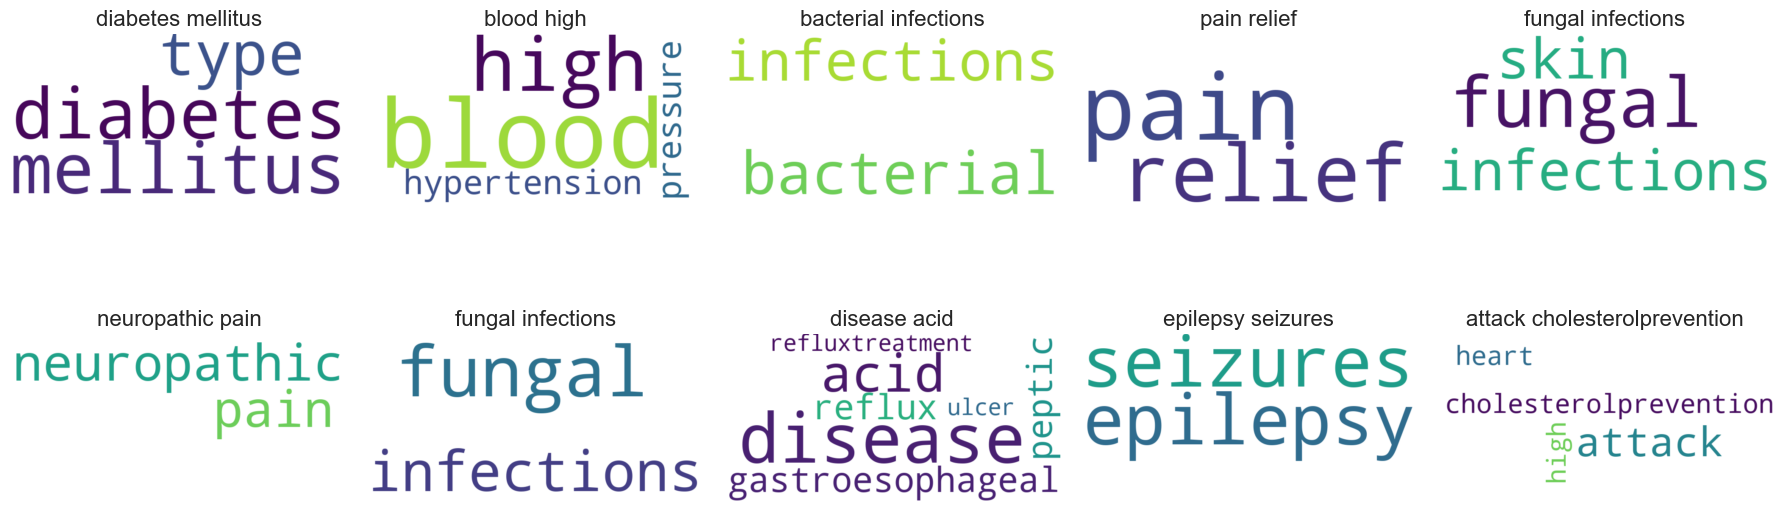

In [275]:
# Set up the 2x5 grid for subplots
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

# Generate word clouds and plot for each community
for i, community in enumerate(top_communities):
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Uses'].dropna().tolist()
    
    # Skip empty communities
    if not community_texts:
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    if not tfidf_scores:
        continue  # Skip if no TF-IDF scores are available

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    
    # Plot on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{community_names.get(community, "Community " + str(community))}', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('community_wordclouds.png', dpi=300)
plt.tight_layout()
plt.show()

Generate Word Clouds for Each Community's 'Composition' Column

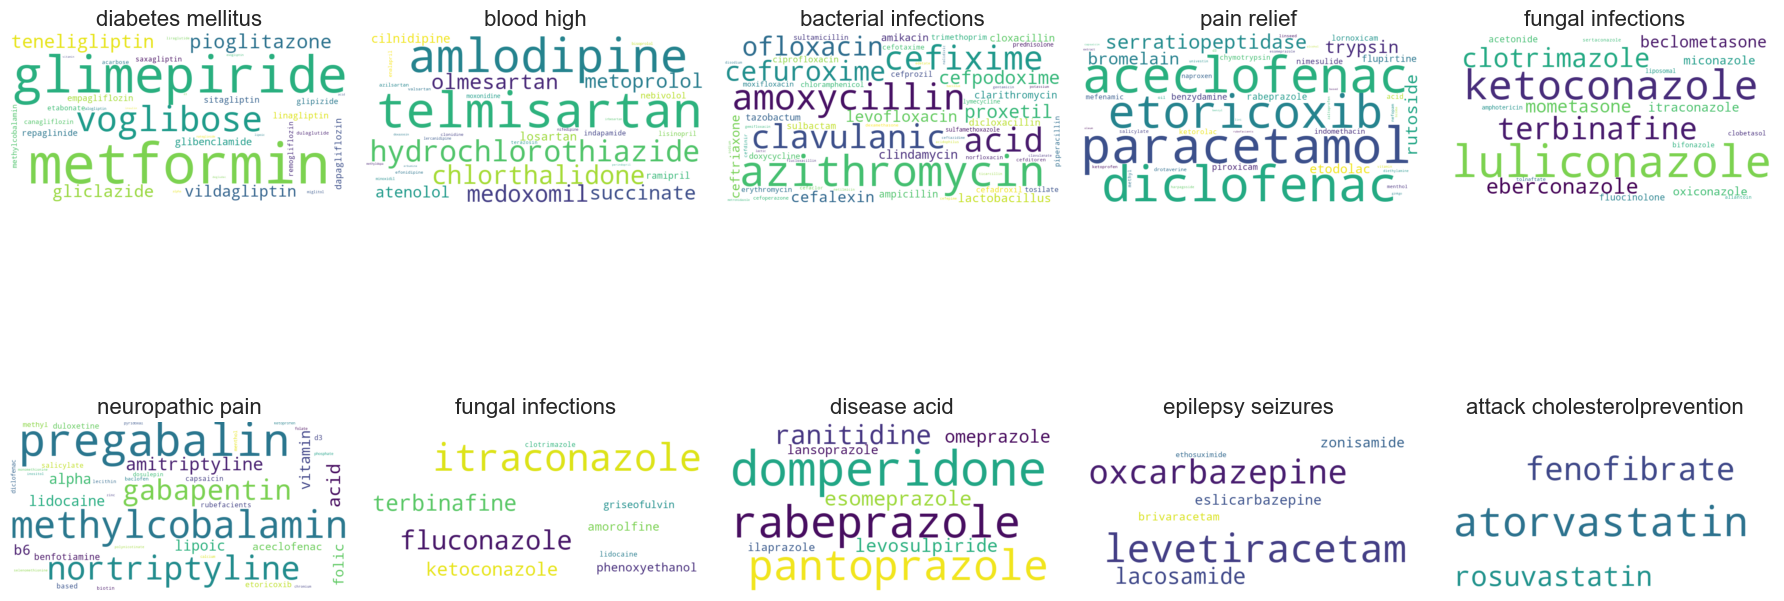

In [276]:
data['Composition'] = data['Composition'].apply(lambda x: clean_text(str(x)))

# Set up the 2x5 grid for subplots
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

# Generate word clouds and plot for each community
for i, community in enumerate(top_communities):
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Composition'].dropna().tolist()
    
    # Skip empty communities
    if not community_texts:
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    if not tfidf_scores:
        continue  # Skip if no TF-IDF scores are available

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    
    # Plot on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{community_names.get(community, "Community " + str(community))}', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('community_wordclouds.png', dpi=300)
plt.show()

Generate Word Clouds for Each Community's 'Side Effects' Column

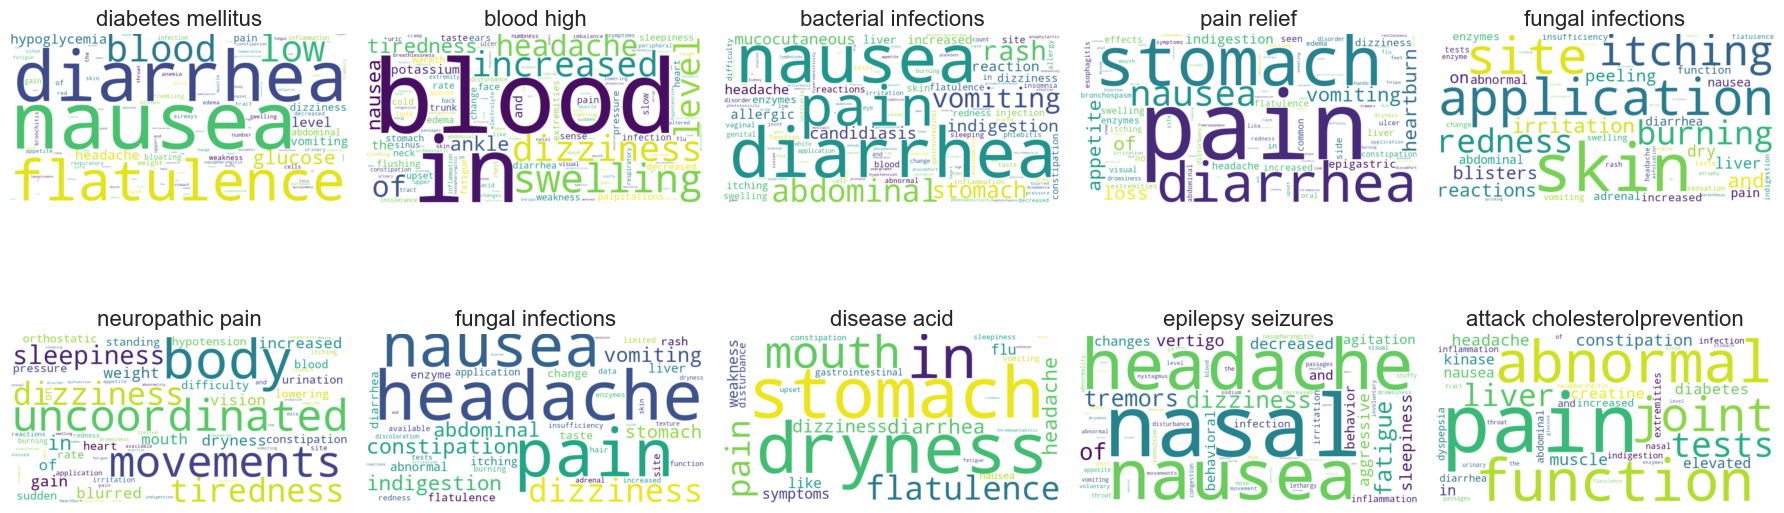

In [277]:
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

for i, community in enumerate(top_communities):
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Side_effects'].dropna().tolist()
    
    # Skip empty communities
    if not community_texts:
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    if not tfidf_scores:
        continue  # Skip if no TF-IDF scores are available

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    
    # Plot on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{community_names.get(community, "Community " + str(community))}', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('community_wordclouds.png', dpi=300)
plt.tight_layout()
plt.show()

## 7. Obsolescence Analysis of Medicines Using TF-IDF, Similarity Metrics, and Community Detection

In this section, the goal is to identify medicines that are likely to become obsolete based on their similarity to other medicines and their associated ratings. By applying TF-IDF analysis to the "Uses" column, we can uncover relationships between medicines based on their descriptions. This is complemented by calculating similarity metrics to group similar medicines, evaluating their ratings, and computing an "obsolescence score" to identify those most at risk.
Steps Overview
- TF-IDF Computation: Applied to transform the "Uses" column of the dataset into numerical representations, capturing the importance of words in medicine descriptions.
- Similarity Matrix Generation: A cosine similarity matrix is computed from the TF-IDF matrix to identify how similar each medicine is to the others.
- Identification of Similar Medicines: Medicines with a similarity score above a set threshold are grouped, allowing for the analysis of their relationship based on shared components.
- Delta Calculation: The average and minimum differences in ratings between a medicine and its similar counterparts are calculated to highlight deviations that contribute to obsolescence.
- Obsolescence Score: A scoring system is established to rank medicines based on their potential obsolescence, taking into account rating discrepancies, the number of similar items, and their baseline rating.
- Community Detection Analysis: The communities used are the one found in section 3 of the notebook. The distance from the community center (obsolescence score) is calculated for each medicine.

In [278]:
def calculate_tfidf(texts):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix

In [279]:
# Load data
data = pd.read_csv('data_with_rating_score.csv')

uses = data['Uses'].tolist()
ratings = data['rating_score'].values

# Calculate TF-IDF matrix
tfidf_matrix = calculate_tfidf(uses)

# Compute similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# Identify similar medicines
similar_meds = {}
threshold = 0.75
for i, row in enumerate(similarity_matrix):
    similar = np.where(row >= threshold)[0]
    similar_meds[i] = similar

# Analyze medicines and calculate scores
medicine_scores = []
for i, rating in enumerate(ratings):
    similar_indices = similar_meds[i]
    if len(similar_indices) > 0:
        similar_ratings = ratings[similar_indices]
        avg_rating = np.mean(similar_ratings)
        min_rating = np.min(similar_ratings)
        
        delta_avg = rating - avg_rating
        delta_min = rating - min_rating
        count_similar = len(similar_indices)
        
        medicine_scores.append({
            'Medicine Name': data['Medicine Name'][i],  # Store index
            'rating': rating,
            'delta_avg': delta_avg,
            'delta_min': delta_min,
            'count_similar': count_similar,
            'Uses': data['Uses'][i]
        })

medicine_df = pd.DataFrame(medicine_scores)

# Filter medicines with at least 3 similar ones or negative delta_avg
filtered_meds = medicine_df[
    (medicine_df['count_similar'] >= 3) | (medicine_df['delta_avg'] < 0)
]

# Fix SettingWithCopyWarning
filtered_meds.loc[:, 'obsolescence_score'] = (
    - 0.5 * filtered_meds['delta_avg'] - 0.3 * filtered_meds['delta_min'] - 0.2 * filtered_meds['rating']
)

# Select top 5% medicines based on obsolescence score
num_to_select = max(1, int(0.05 * len(filtered_meds)))
top_5_percent = filtered_meds.nlargest(num_to_select, 'obsolescence_score')

# Display results
print("Top 5% Medicines Likely to Become Obsolete:")
top_5_percent[['Medicine Name', 'Uses', 'rating', 'obsolescence_score']].head(5)


Top 5% Medicines Likely to Become Obsolete:


C:\Users\AdrianLopez\AppData\Local\Temp\ipykernel_17960\1556841403.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Medicine Name  \
3326      Gloritel CT 40 Tablet   
3863       Inditel AH 40 Tablet   
6011   Myotan CT 40/6.25 Tablet   
7310  Olmewon Plus 20 mg Tablet   
8099     Protol 25 TL Tablet PR   

                                                 Uses  rating  \
3326               Hypertension (high blood pressure)     0.0   
3863               Hypertension (high blood pressure)     0.0   
6011               Hypertension (high blood pressure)     0.0   
7310               Hypertension (high blood pressure)     0.0   
8099  Treatment of Hypertension (high blood pressure)     0.0   

      obsolescence_score  
3326            3.441923  
3863            3.441923  
6011            3.441923  
7310            3.441923  
8099            3.441923

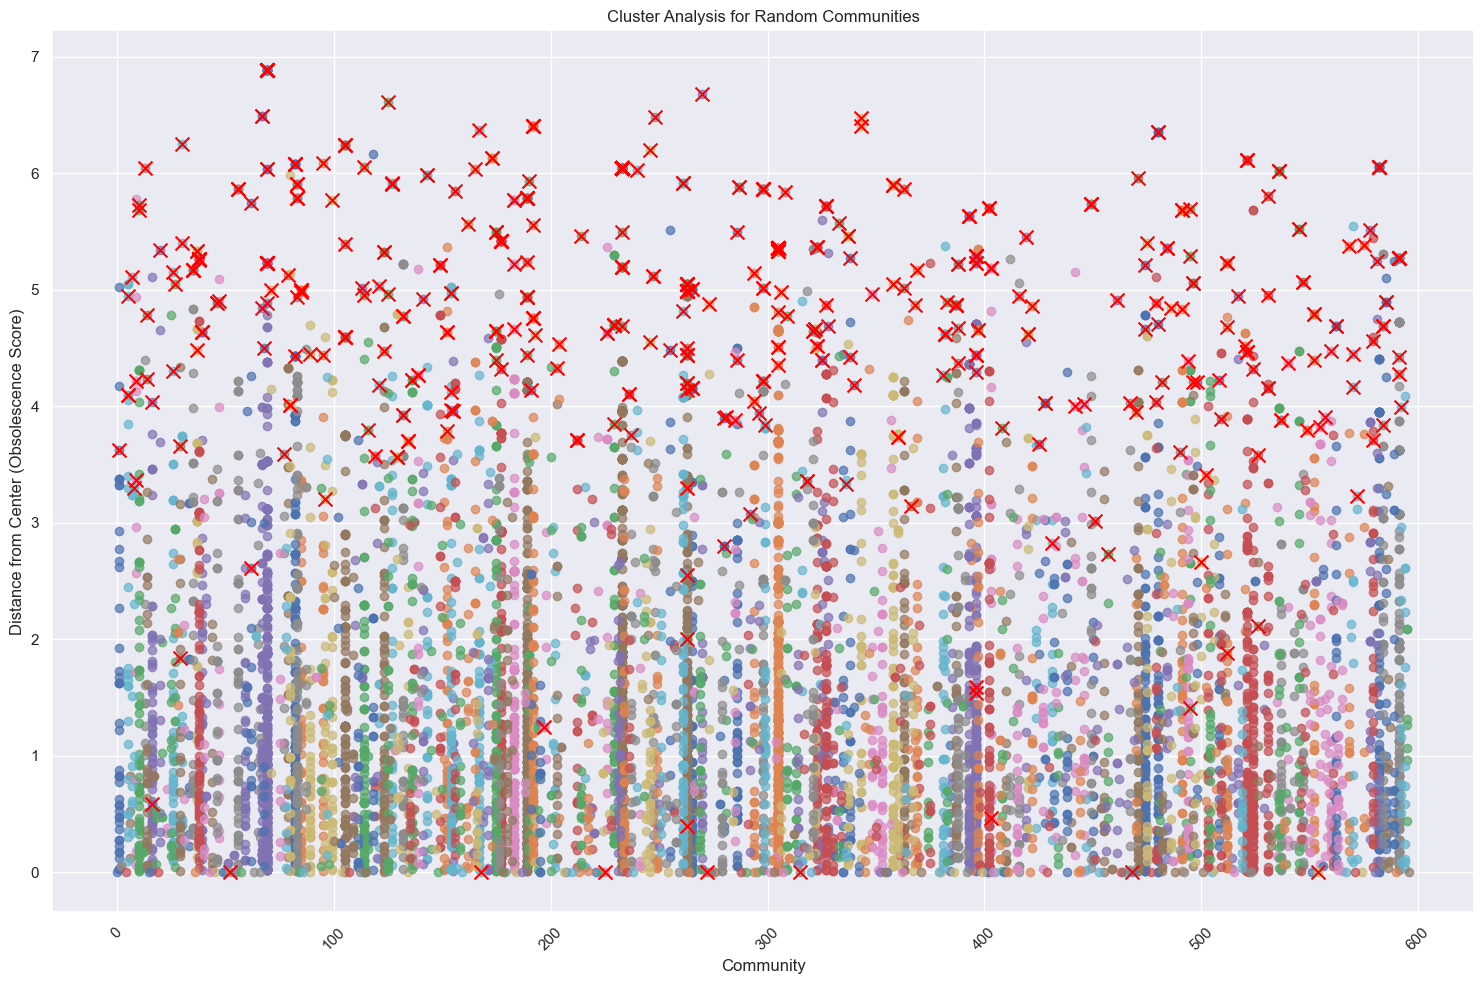

In [280]:
# Load data
data2 = pd.read_csv('data_with_communities.csv')
data2['obsolescence_score'] = filtered_meds['obsolescence_score']
# data2['medicine_index'] = 
# Step 1: Extract relevant columns
# data2['Community'] = data2.iloc[:, 10]  # 11th column for Community

# random_communities = np.random.choice(data2['Community'].unique(), 50, replace=False)
# filtered_data2 = data2[data2['Community'].isin(random_communities)]

filtered_data2 = data2
random_communities = filtered_data2['Community'].unique()

community_groups = filtered_data2.groupby('Community')
cluster_centers = community_groups['obsolescence_score'].mean()

filtered_data2['distance_from_center'] = filtered_data2.apply(
    lambda row: abs(row['obsolescence_score'] - cluster_centers[row['Community']]),
    axis=1
)

filtered_data2['Medicine Name'] = filtered_data2.iloc[:, 0]

# df1_common = df1[df1["column_name"].isin(df2["column_name"])]:
marked_data = filtered_data2[filtered_data2['Medicine Name'].isin(top_5_percent['Medicine Name'])]
# else:
#     marked_data = pd.DataFrame()

plt.figure(figsize=(15, 10))

# Plot the data for each random community
for community in random_communities:
    community_data = filtered_data2[filtered_data2['Community'] == community]
    
    # Scatter plot for community data
    plt.scatter(
        [community] * len(community_data),  # x-axis: Community ID
        community_data['distance_from_center'],  # y-axis: distance from center
        label=f"Community {community}",
        alpha=0.7,
    )

# Scatter plot for marked data
plt.scatter(
    marked_data['Community'],  # x-axis: Community ID
    marked_data['distance_from_center'],  # y-axis: distance from center
    color='red',
    marker='x',
    s=100,  # Size of the marker
)

# Adding labels and title
plt.xlabel("Community")
plt.ylabel("Distance from Center (Obsolescence Score)")
plt.title("Cluster Analysis for Random Communities")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()